# PyTorch Image Alignment

Tasks:
- Load reference frame
- Compare optimization performance in torch versus tensorflow



## Reference Code

In [1]:
import torch
import torchvision
import torch.nn.functional as F

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from transform import SE3, SO3
from se3 import se3_log_map, se3_exp_map
import roma

2023-03-27 09:31:27.678295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 09:31:28.522577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oliland/miniconda3/envs/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-27 09:31:28.522623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/oliland/miniconda3/envs/tensorflow/lib

In [3]:
reference_image = torch.from_numpy(np.load('reference-image.npy'))
reference_depth = torch.from_numpy(np.load('reference-depth.npy'))
target_image    = torch.from_numpy(np.load('target.npy'))
params          = torch.tensor([[0.0, 0.0, 0.45, 0.01, -0.02, 0.10]]).tile(2, 1)
params_est      = torch.tensor([[0.0, 0.0, 0.15, 0.00,  0.00, 0.00]]).tile(2, 1)
transform       = se3_exp_map(params).mT
transform_est   = se3_exp_map(params_est).mT
K               = torch.tensor([
    [0.5, 0, 0.5],  # 160 / (160 * 2)
    [0, 2/3, 0.5],  # 160 / (120 * 2)
    [0,   0, 1.0],
])

In [4]:
true_euler = [ 0.01, -0.02, 0.10 ]
true_quat = Rotation.from_euler('xyz', true_euler).as_quat()
true_translation = [ 0.00, 0.00, 0.45 ]

init_euler = [ 0.0, 0.0, 0.0 ]
init_quat = Rotation.from_euler('xyz', init_euler).as_quat()
init_translation = [ 0.00, 0.00, 0.15 ]

# T_target_reference[0:3] = init_translation
# T_target_reference[3:7] = init_quat

In [5]:
# se3_exp_map(params_est).mT

In [6]:
# SE3.exp(params_est), init_quat
# SE3.exp(params)[0].numpy(), np.concatenate([true_translation, true_quat])

### Objects

In [7]:
class ImageFrame:
    
    def __init__(self):
        self.image = None
        self.weight = None
        self.camera_model = None
        self.T_target_reference = None
        self.image_index = -1

class ImageKeyframe:

    def __init__(self):
        self.image = None
        self.depth = None
        self.weight = None
        self.camera_model = None
        self.image_index = -1

In [8]:
reference = ImageKeyframe()
reference.image  = tf.convert_to_tensor(reference_image)
reference.depth  = tf.convert_to_tensor(reference_depth)
reference.weight = tf.convert_to_tensor(torch.ones_like(reference_depth))
reference.camera_model = tf.convert_to_tensor([160, 160, 160, 120.0])

2023-03-27 09:31:40.684632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 09:31:40.687433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 09:31:40.687524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 09:31:40.688824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [9]:
target = ImageFrame()
target.image  = tf.convert_to_tensor(target_image)
target.weight = tf.convert_to_tensor(torch.ones_like(reference_depth))
target.camera_model = reference.camera_model
target.T_target_reference = SE3.exp(params_est)

In [10]:
reference.weight.shape

TensorShape([2, 240, 320, 1])

### Optimizer

In [11]:
class ImageTracker:

    def __init__(self, reference):

        # Initialize member variables.
        self._reference = reference
        self.hessian_epsilon = 1e-6
        self.robust_norm = "huber"
        self.robust_constant = 0.2
        self.iterations = 1

    def initialize(self, target=None):

        # Build initial problem.
        self._query_image_resolution()
        self._compute_hessian_delta()
        self._compute_pointcloud()
        self._compute_jacobian()

        # Check if target frame provided.
        if target is not None:

            # Build target projection matrix.
            self._Kt = self._get_projection_matrix(target.camera_model)

            # Store reference to target.
            self._target = target

    def step_once(self):

        # Perform single tracking iteration.
        self._update_track(self._target)

        # Return trackings results.
        return self._target.T_target_reference, self._hessian

    def track(self, target):

        # Store reference to target.
        self._target = target

        # Build target projection matrix.
        self._Kt = self._get_projection_matrix(target.camera_model)

        # Perform each tracking iteration.
        for iteration in range(self.iterations):
            self._update_track(target)

    def _update_track(self, target):

        # Build tracking problem.
        self._compute_residuals(target)
        self._compute_weighted_jacobian()
        self._compute_gradient()
        self._compute_hessian()

        # Solve and apply solution.
        self._solve_problem()
        self._apply_update(target)

    def _compute_residuals(self, target):

        # Transform pointcloud to target frame with current estimate.
        Xt = SE3.transform_points(target.T_target_reference, self._pointcloud)

        # Project points onto target image plane.
        uvw = tf.matmul(Xt, self._Kt, transpose_b=True)

        # Normalize and dehomogenize points.
        ones = tf.ones_like(uvw[..., 2:3])
        denom = tf.where(Xt[..., 2:3] > 0.0, uvw[..., 2:3], ones)
        uv = uvw[..., 0:2] / denom

        # Sample target image at computed coordinates.
        target_image = tfa.image.resampler(target.image, uv - 0.5)

        # Reshape both images into a list of channel vectors.
        residual_shape = [self._batch_size, -1, self._channels]
        reference_image = tf.reshape(self._reference.image, residual_shape)
        target_image = tf.reshape(target_image, residual_shape)

        # Sample target saliency weights at coordinates.
        target_weight = tfa.image.resampler(target.weight, uv - 0.5)
        target_weight = tf.reshape(target_weight, [self._batch_size, -1, 1])

        # Compute unweighted residuals between images.
        self._residuals = reference_image - target_image

        # Initialize invalid point search.
        zeros = tf.zeros_like(self._weight)
        umax = tf.cast(self._image_cols, uv.dtype) - 0.5
        vmax = tf.cast(self._image_rows, uv.dtype) - 0.5

        # Compute mask of invalid projection points.
        mask = tf.logical_and(Xt[..., 2:3] > 0.0,
               tf.logical_and(uv[..., 0:1] > 0.5,
               tf.logical_and(uv[..., 1:2] > 0.5,
               tf.logical_and(uv[..., 0:1] < umax,
                              uv[..., 1:2] < vmax))))
        
        # Compute weights for current iteration.
        mask_weight = tf.cast(mask, self._weight.dtype)
        self._iter_weight = mask_weight * self._weight * target_weight

    def _compute_weighted_jacobian(self):

        # Compute collective photometric error for each pixel.
        abs_error = tf.abs(self._residuals)

        # Determine when error is small enough to use default weight.
        small_error = abs_error < self.robust_constant

        # Cauchy
        rDivk = self._residuals / self.robust_constant
        robust_weight = 1 / (1 + rDivk * rDivk)
        
        ##################

        # Compute combined saliency and Huber-norm weights.
        weight_sq = tf.expand_dims(self._iter_weight * robust_weight, -1)**2

        # Reshape Jacobian to simplify re-weighting.
        temp_shape = (self._batch_size, -1, self._channels, SE3.DoF)
        jacobian = tf.reshape(self._jacobian, temp_shape)

        # Apply final weights to Jacobian.
        final_shape = (self._batch_size, -1, SE3.DoF)
        self._weighted_jacobian = tf.reshape(weight_sq * jacobian, final_shape)

    def _compute_gradient(self):
        
        # Flatten residuals into a single vector.
        residuals = tf.reshape(self._residuals, (self._batch_size, -1, 1))

        # Compute gradient at current point on cost-surface: J'*W*r.
        self._gradient = tf.matmul(self._weighted_jacobian, residuals,
                transpose_a=True)

    def _compute_hessian(self):

        # Compute approximation of the Hessian: J'*W^2*J.
        # Note: Theoretically: (WJ)' * (WJ), in practice (W^2J)' * J
        self._hessian = tf.matmul(self._weighted_jacobian, self._jacobian,
                transpose_a=True)

        # Add epsilon to ensure invertability.
        self._hessian += self._hessian_delta

    def _solve_problem(self):

        # Solve the constructed problem to obtain transform increment.
        self._update = tf.linalg.solve(self._hessian, self._gradient)
        self._update = tf.squeeze(self._update, -1)

        # Check numerics after solve.
        self._update = tf.debugging.check_numerics(self._update, "Tracking update")

    def _apply_update(self, target):

        # Apply update to relative transform.
        target.T_target_reference = SE3.transform_transform(
                target.T_target_reference, SE3.exp(self._update))

    def _get_projection_matrix(self, camera_model):

        # Get components of reference camera model.
        fx, fy, cx, cy = tf.unstack(camera_model, axis=-1)

        # Get constants of same shape.
        _0 = tf.zeros_like(fx)
        _1 = tf.ones_like(fx)

        # Build and return final projection matrix.
        K = tf.stack((fx, _0, cx, _0, fy, cy, _0, _0, _1), -1)
        return tf.reshape(K, (-1, 3, 3))

    def _get_inverse_projection_matrix(self, camera_model):

        # Get components of reference camera model.
        fx, fy, cx, cy = tf.unstack(camera_model, axis=-1)

        # Compute inverse components.
        ifx = 1.0 / fx
        ify = 1.0 / fy
        icx = -cx * ifx
        icy = -cy * ify

        # Get constants of same shape.
        _0 = tf.zeros_like(ifx)
        _1 = tf.ones_like(ifx)

        # Build and return final inverse projection matrix.
        Kinv = tf.stack((ifx, _0, icx, _0, ify, icy, _0, _0, _1), -1)
        return tf.reshape(Kinv, (-1, 3, 3))

    def _query_image_resolution(self):

        # Get reference image dimensions.
        image_shape = tf.shape(self._reference.image)
        self._batch_size = image_shape[0]
        self._image_rows = image_shape[1]
        self._image_cols = image_shape[2]
        self._channels = image_shape[3]

    def _compute_hessian_delta(self):

        # Create hessian diagonal delta.
        epsilon = self.hessian_epsilon
        dtype = self._reference.image.dtype
        self._hessian_delta = epsilon * tf.eye(SE3.DoF, dtype=dtype)

    def _compute_pointcloud(self):

        # Get reference depth & saliency maps.
        weight = self._reference.weight
        depth = self._reference.depth

        # Compute UV-coordinates for entire image.
        half = tf.constant(0.5, dtype=weight.dtype)
        uend = tf.cast(self._image_cols, half.dtype) - half
        vend = tf.cast(self._image_rows, half.dtype) - half
        urange = tf.linspace(half, uend, self._image_cols)
        vrange = tf.linspace(half, vend, self._image_rows)
        u, v = tf.meshgrid(urange, vrange)

        # Flatten image coordinate vectors.
        u = tf.reshape(u, [1, -1])
        v = tf.reshape(v, [1, -1])

        # Homogenize image coordinates.
        uvw = tf.stack((u, v, tf.ones_like(u)), -1)

        # Convert image depth to flat vector.
        depth = tf.reshape(depth, [self._batch_size, -1, 1])

        # Unproject image coordinates to 3D space.
        camera_model = self._reference.camera_model
        Kinv = self._get_inverse_projection_matrix(camera_model)
        self._pointcloud = depth * tf.matmul(uvw, Kinv, transpose_b=True)

        # Copy residuals weights, zeroing-out invalid depths (deleted).
        weight = tf.reshape(weight, [self._batch_size, -1, 1])
        self._weight = weight

    def _compute_jacobian(self):

        # Get components of reference camera model.
        camera_model = tf.expand_dims(self._reference.camera_model, -1)
        fx, fy, cx, cy = tf.unstack(camera_model, axis=-2)

        # Get components of pointcloud.
        px, py, pz = tf.unstack(self._pointcloud, axis=-1)

        # Get constants of same shape.
        _0 = tf.zeros_like(px)
        _1 = tf.ones_like(px)

        # Compute z-inverse.
        iz_denom = tf.where(pz > 0, pz, _1)
        iz = tf.where(pz > 0, 1.0 / iz_denom, _0)
        iz_sq = iz * iz

        # Compute delta-point / delta-transform.
        row0 = tf.stack([ _1, _0, _0,  _0,  pz, -py ], axis=-1)
        row1 = tf.stack([ _0, _1, _0, -pz,  _0,  px ], axis=-1)
        row2 = tf.stack([ _0, _0, _1,  py, -px,  _0 ], axis=-1)
        dp_dt = tf.stack([ row0, row1, row2 ], axis=-2)

        # Compute delta-coord / delta-point.
        row0  = tf.stack([      _0, fy * iz, -fy * py * iz_sq ], axis=-1)
        row1  = tf.stack([ fx * iz,      _0, -fx * px * iz_sq ], axis=-1)
        du_dp = tf.stack([ row0, row1 ], axis=-2)

        # Compute delta-image / delta-coord.
        inv_sobel_norm = 0.125
        image = self._reference.image
        di_du = tf.image.sobel_edges(image) * inv_sobel_norm

        # Flatten image gradient matrix.
        di_du = tf.reshape(di_du, [ self._batch_size, -1, self._channels, 2 ])

        # Compute delta-image / delta-transform:
        di_dt = tf.matmul(di_du, tf.matmul(du_dp, dp_dt))

        # Reshape derivatives to match jacobian-transpose matrix.
        self._jacobian = tf.reshape(di_dt, [ self._batch_size, -1, SE3.DoF ])

### Testing

In [12]:
tracker = ImageTracker(reference)
T_init = target.T_target_reference
print(T_init)

tf.Tensor(
[[0.   0.   0.15 0.   0.   0.   1.  ]
 [0.   0.   0.15 0.   0.   0.   1.  ]], shape=(2, 7), dtype=float32)


In [13]:
tracker.initialize(target)

2023-03-27 09:31:44.016014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
tracker._compute_residuals(target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


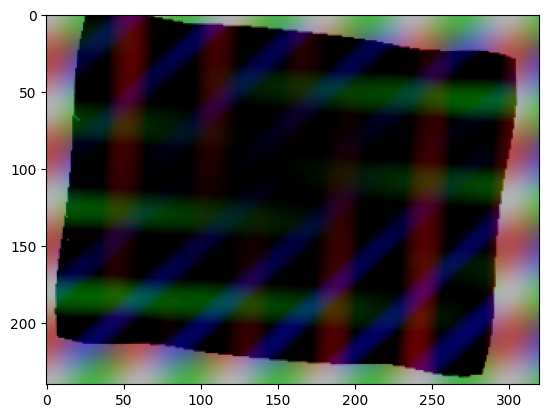

In [15]:
residuals = tracker._residuals[0].numpy().reshape(240, 320, 3)
plt.imshow(residuals)
plt.show()

In [16]:
r = 0.050
c = 0.500

# # Cauchy
# ======================
# == ITERATIONS: 32 ==
# == CONSTANT: 10.000000 ==
# Translation error: 0.001303
# Rotation error:    0.000312
# ======================

# # Geman-McClure
# ======================
# == ITERATIONS: 32 ==
# == CONSTANT: 1.000000 ==
# Translation error: 0.001450
# Rotation error:    0.000250
# ======================

# # Huber
# ======================
# == ITERATIONS: 32 ==
# == CONSTANT: 0.5000 ==
# Translation error: 0.001302
# Rotation error:    0.000312
# ======================

for iterations in range(1, 32, 2):
# for iterations in [8]:
    for robust_constant in [1.0]:
    # for robust_constant in np.linspace(c-r, c+r, 25):

        # tracker.robust_norm = "l2"
        # tracker.robust_norm = "huber"
        # tracker.robust_norm = "trunc-l2"
        # tracker.robust_norm = "trunc-l1"
        # tracker.robust_norm = "l1"
        # tracker.robust_norm = "geman-mcclure"
        tracker.robust_norm = "cauchy"

        target.T_target_reference = T_init
        tracker.iterations = iterations
        tracker.robust_constant = robust_constant
        tracker.initialize()
        tracker.track(target)

        T_expected = np.zeros(7, np.float32)
        T_expected[0:3] = true_translation
        T_expected[3:7] = true_quat
        T_expected = tf.convert_to_tensor(T_expected)
        # T_expected = SE3.exp(params)[0]

        T_found = target.T_target_reference
        
        T = SE3.inverse(T_expected)
        T_error = SE3.transform_transforms(T, T_found)
        T_error = SE3.log(T_error).numpy()
        zeros = np.zeros_like(T_error)

        # plt.imshow(tracker._residuals[0].numpy().reshape(240, 320, 3))
        # plt.show()
        assert(T_error.shape == (2, 6))
        print("== ITERATIONS: %d ==" % iterations)
        print("== CONSTANT: %0.4f ==" % robust_constant)
        print("Translation error: %0.8f" % np.linalg.norm(T_error[0, 0:3]))
        print("Rotation error:    %0.8f" % np.linalg.norm(T_error[0, 3:6]))
        print("======================")


2023-03-27 09:31:44.714647: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x56171370


== ITERATIONS: 1 ==
== CONSTANT: 1.0000 ==
Translation error: 0.27942368
Rotation error:    0.09694690
== ITERATIONS: 3 ==
== CONSTANT: 1.0000 ==
Translation error: 0.27545077
Rotation error:    0.12841034
== ITERATIONS: 5 ==
== CONSTANT: 1.0000 ==
Translation error: 0.14448293
Rotation error:    0.06994142
== ITERATIONS: 7 ==
== CONSTANT: 1.0000 ==
Translation error: 0.02687605
Rotation error:    0.01280608
== ITERATIONS: 9 ==
== CONSTANT: 1.0000 ==
Translation error: 0.00233068
Rotation error:    0.00092872
== ITERATIONS: 11 ==
== CONSTANT: 1.0000 ==
Translation error: 0.00134077
Rotation error:    0.00029751
== ITERATIONS: 13 ==
== CONSTANT: 1.0000 ==
Translation error: 0.00136059
Rotation error:    0.00028630
== ITERATIONS: 15 ==
== CONSTANT: 1.0000 ==
Translation error: 0.00136145
Rotation error:    0.00028598
== ITERATIONS: 17 ==
== CONSTANT: 1.0000 ==
Translation error: 0.00136124
Rotation error:    0.00028605
== ITERATIONS: 19 ==
== CONSTANT: 1.0000 ==
Translation error: 0.0013

In [17]:
# np.save('target.npy', target.image)

In [18]:
# np.save('reference-image.npy', reference.image)
# np.save('reference-depth.npy', reference.depth)

## Imports

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [25]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [26]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

## Perspective Geometry

In [27]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t

In [28]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [29]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [30]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [31]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [32]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [33]:
def grid_sample(image, flow):
    """
    Hacky implementation of torch.nn.functional.grid_sample,
    created so that the derivative can be computed with jacfwd.
    """
    N, C, IH, IW = image.shape
    _, H, W, _ = flow.shape

    ix = flow[..., 0]
    iy = flow[..., 1]

    ix = ((ix + 1) / 2) * (IW-1);
    iy = ((iy + 1) / 2) * (IH-1);
    
    with torch.no_grad():
        ix_nw = torch.floor(ix);
        iy_nw = torch.floor(iy);
        ix_ne = ix_nw + 1;
        iy_ne = iy_nw;
        ix_sw = ix_nw;
        iy_sw = iy_nw + 1;
        ix_se = ix_nw + 1;
        iy_se = iy_nw + 1;

    nw = (ix_se - ix)    * (iy_se - iy)
    ne = (ix    - ix_sw) * (iy_sw - iy)
    sw = (ix_ne - ix)    * (iy    - iy_ne)
    se = (ix    - ix_nw) * (iy    - iy_nw)

    with torch.no_grad():
        ix_nw = torch.clamp(ix_nw, 0, IW-1)
        iy_nw = torch.clamp(iy_nw, 0, IH-1)
        ix_ne = torch.clamp(ix_ne, 0, IW-1)
        iy_ne = torch.clamp(iy_ne, 0, IH-1)
        ix_sw = torch.clamp(ix_sw, 0, IW-1)
        iy_sw = torch.clamp(iy_sw, 0, IH-1)
        ix_se = torch.clamp(ix_se, 0, IW-1)
        iy_se = torch.clamp(iy_se, 0, IH-1)

    image = image.view(N, C, IH * IW)

    nw_val = torch.gather(image, 2, (iy_nw * IW + ix_nw).long().view(N, 1, H * W).repeat(1, C, 1))
    ne_val = torch.gather(image, 2, (iy_ne * IW + ix_ne).long().view(N, 1, H * W).repeat(1, C, 1))
    sw_val = torch.gather(image, 2, (iy_sw * IW + ix_sw).long().view(N, 1, H * W).repeat(1, C, 1))
    se_val = torch.gather(image, 2, (iy_se * IW + ix_se).long().view(N, 1, H * W).repeat(1, C, 1))

    return (
        nw_val.view(N, C, H, W) * nw.view(N, 1, H, W) +    
        ne_val.view(N, C, H, W) * ne.view(N, 1, H, W) +       
        sw_val.view(N, C, H, W) * sw.view(N, 1, H, W) +
        se_val.view(N, C, H, W) * se.view(N, 1, H, W)
    )

In [34]:
def resample(depth, K, transform, target):
    """
    Backproject a depth map with K and transform it into a new reference frame T.
    Sample colors from the target image.
    """
    points_3d = backproject(depth, K)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    return grid_sample(target, points_2d)

## Gauss-Newton

In [36]:
class GaussNewtonImageOptimizer(torch.nn.Module):
    
    def __init__(self, K, image, depth):
        super().__init__()
        self.K = K
        self.image = image
        self.depth = depth
        self.residuals_grad = torch.func.jacfwd(self.residuals)

    def residuals(self, params, target):
        transform = transform_from_params(params).unsqueeze(1)
        resampled = resample(self.depth, self.K, transform, target)
        residuals = self.image - resampled
        return residuals.ravel()

    def update_step(self, params, target):
        r = self.residuals(params, target)
        with torch.no_grad():
            J = self.residuals_grad(params, target).squeeze()
            H = J.mT @ J
        return torch.linalg.lstsq(H, J.mT @ -r).solution
    
    def solve(self, params, target, iterations):
        output = params.unsqueeze(0)
        for i in range(iterations):
            update = self.update_step(output, target).unsqueeze(0)
            output = params_from_transform(
                transform_from_params(output) @
                transform_from_params(update)
            )
        return output

    def forward(self, batch, target, iterations=30):
        # TODO: Try to use VMap for batching
        output = batch.clone()
        for i, params in enumerate(batch):
            output[i] = self.solve(params, target, iterations)
        return output

In [37]:
tracker = ImageTracker(reference)
T_init = target.T_target_reference
print(T_init)

tf.Tensor(
[[-8.2025555e-04 -1.0862224e-03  4.4998077e-01  5.6008850e-03
  -9.8255686e-03  4.9993042e-02  9.9868566e-01]
 [-8.2025555e-04 -1.0862224e-03  4.4998077e-01  5.6008850e-03
  -9.8255686e-03  4.9993042e-02  9.9868566e-01]], shape=(2, 7), dtype=float32)


In [38]:
tracker.initialize(target)

In [39]:
tracker._compute_residuals(target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


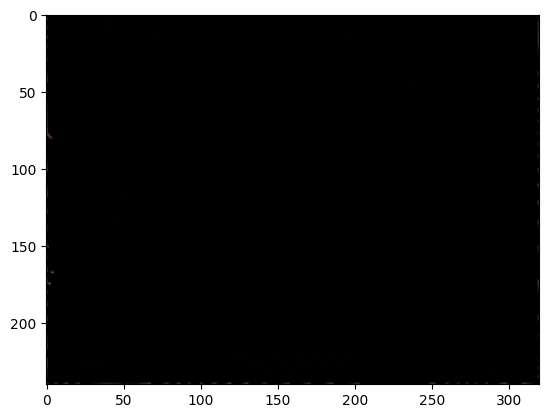

In [40]:
residuals = tracker._residuals[0].numpy().reshape(240, 320, 3)
plt.imshow(residuals)
plt.show()

In [41]:
T = transform_from_params(params_est)

In [42]:
# guess = reproject(reference_depth.permute(0, 3, 1, 2), target_image.permute(0, 3, 1, 2), K, T)
# # transformed = reproject
# plt.imshow(reference_image[0] - guess.permute(0, 2, 3, 1)[0])
# plt.show()

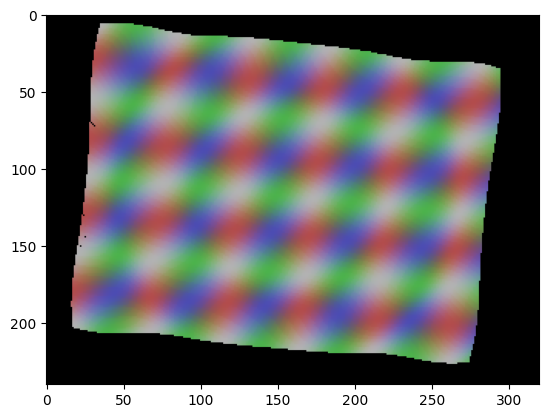

In [43]:
plt.imshow(target.image[0])
plt.show()

In [44]:
optimizer = GaussNewtonImageOptimizer(K, reference_image.permute(0, 3, 1, 2), reference_depth.permute(0, 3, 1, 2))

params = torch.tensor([[0.0, 0.0, 0.45, 0.01, -0.02, 0.10]]).tile(2, 1)
params_est = torch.tensor([[0.0, 0.0, 0.15, 0.0, 0.0, 0.0]]).tile(2, 1)
params_est = optimizer.forward(params_est, target_image.permute(0, 3, 1, 2), iterations=50)

In [45]:
params_est

tensor([[ 2.3434e-03,  2.3873e-04,  4.5745e-01,  1.0480e-02, -1.9271e-02,
          1.0041e-01],
        [ 2.3434e-03,  2.3883e-04,  4.5745e-01,  1.0480e-02, -1.9271e-02,
          1.0041e-01]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


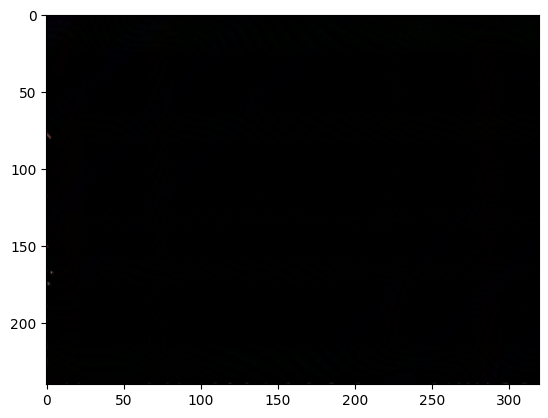

In [46]:
error = optimizer.residuals(params_est, target_image.permute(0, 3, 1, 2))
plt.imshow(error.view(2, 3, 240, 320)[0].permute(1,2,0))
plt.show()

In [47]:
params

tensor([[ 0.0000,  0.0000,  0.4500,  0.0100, -0.0200,  0.1000],
        [ 0.0000,  0.0000,  0.4500,  0.0100, -0.0200,  0.1000]])

In [48]:
params_est.round(decimals=3)

tensor([[ 0.0020,  0.0000,  0.4570,  0.0100, -0.0190,  0.1000],
        [ 0.0020,  0.0000,  0.4570,  0.0100, -0.0190,  0.1000]])

In [49]:
error = se3_log_map(se3_exp_map(params) @ torch.linalg.inv(se3_exp_map(params_est)))

print("Translation error: %0.8f" % np.linalg.norm(error[0, 0:3]))
print("Rotation error:    %0.8f" % np.linalg.norm(error[0, 3:6]))

Translation error: 0.00785717
Rotation error:    0.00096504


In [50]:
# Translation error: 0.00138225
# Rotation error:    0.00027812